In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [6]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [28]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    
    rc = 106.9
    dc = 4.6
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 0.2
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    rc = 107.2
    dc = 5.2
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    annulus = (radius >= 1. ) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0


    sigma = beam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())
    
    signal[~innerregion] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-12, 12)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        grid(alpha=0.7)
        title('$%.3f~GHz$' %cfreq)
    
    return signal, rabins, decbins

0.666643862577 0.0512893268803


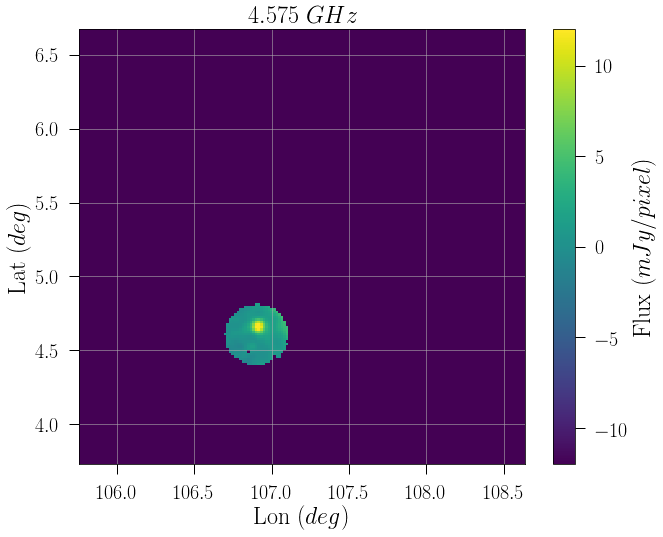

In [29]:
signal, rabins, decbins = calculate_sflux_gal('A')

3.31614145536 0.1022151812


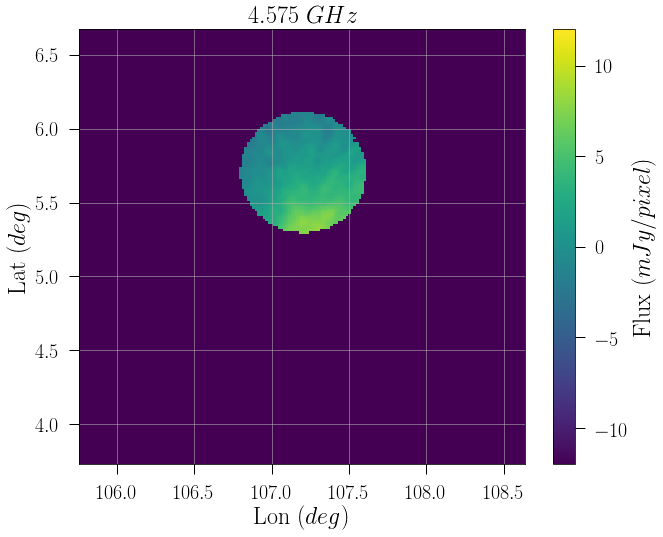

In [22]:
signal, rabins, decbins = calculate_sflux_gal('A')

16.0184076513 0.77055346878


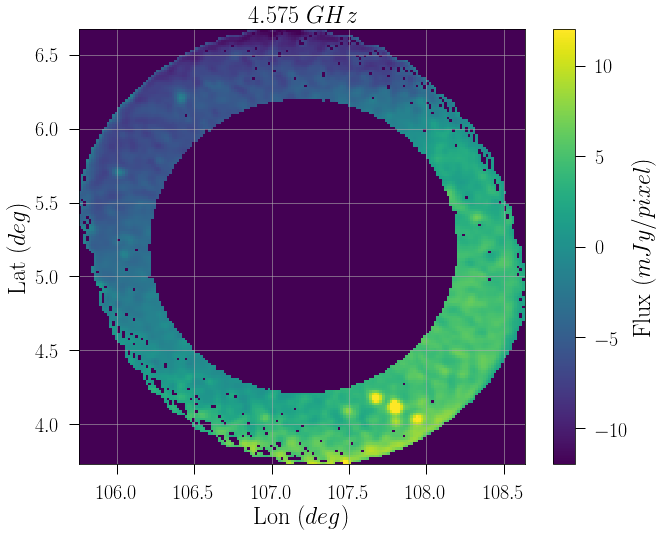

In [17]:
signal, rabins, decbins = calculate_sflux_gal('A')

2.04503850033 0.0790922584014


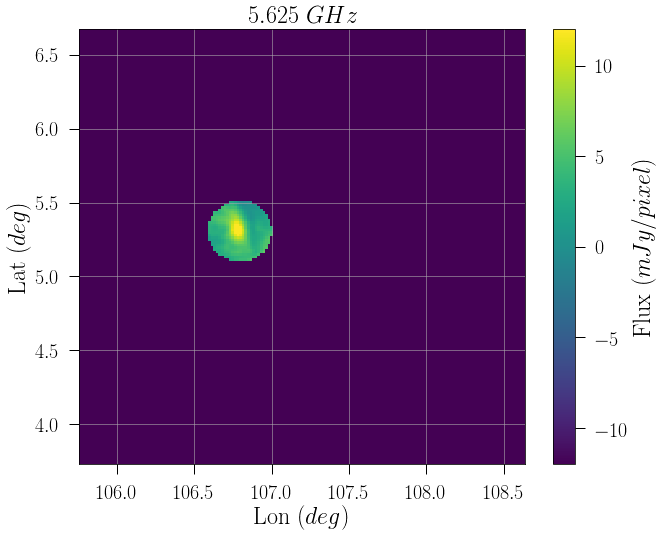

In [66]:
signal, rabins, decbins = calculate_sflux_gal('B')

1.94729277655 0.0980656739575


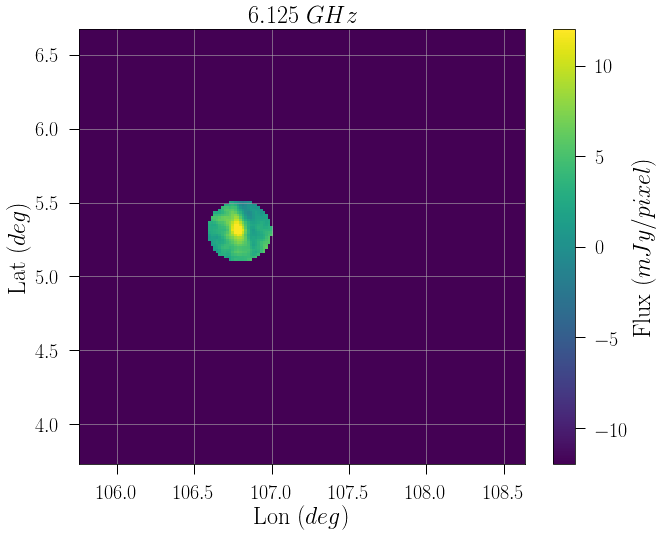

In [67]:
signal, rabins, decbins = calculate_sflux_gal('C')

In [96]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    
    rc = 107.
    dc = 5.5
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 0.2
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    rc = 107.2
    dc = 5.2
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    annulus = (radius >= 1. ) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0

    if smth is None:
        smth = beam
    if smth > 0:
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma)
        shits = gaussian_filter(hits, sigma)
        mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())
    
    signal[~innerregion] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-12, 12)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        grid(alpha=0.7)
        title('$%.3f~GHz$' %cfreq)
    
    return signal, rabins, decbins

1.1242057068 0.0518713239969


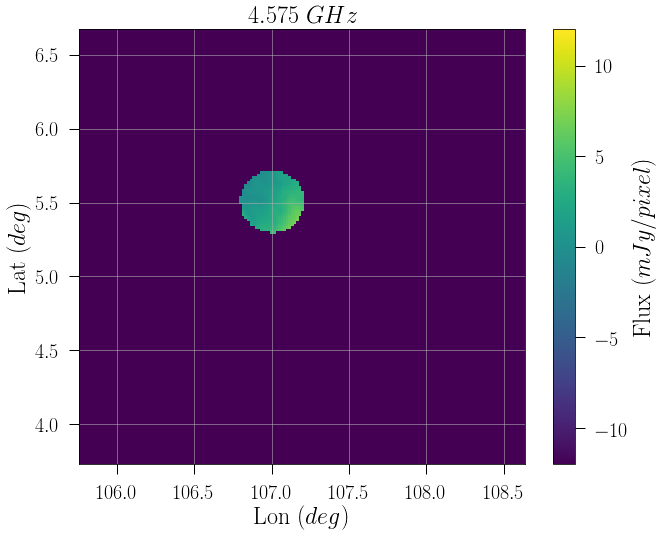

In [97]:
signal, rabins, decbins = calculate_sflux_gal('A')

1.04084096536 0.0796756843671


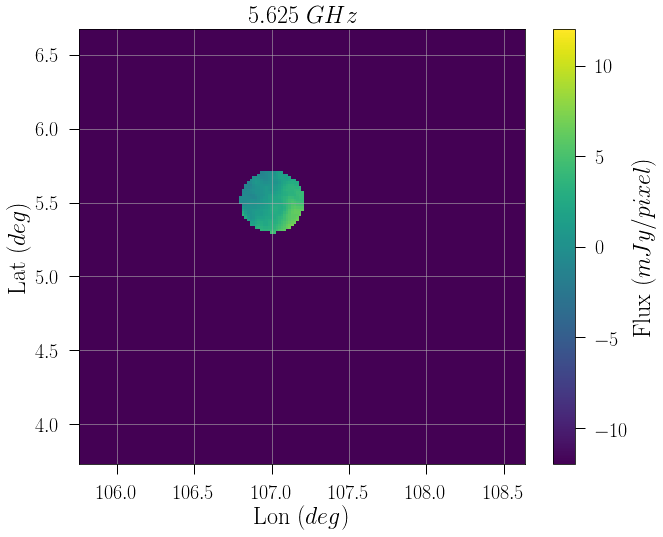

In [98]:
signal, rabins, decbins = calculate_sflux_gal('B')

0.99721091132 0.0987145347713


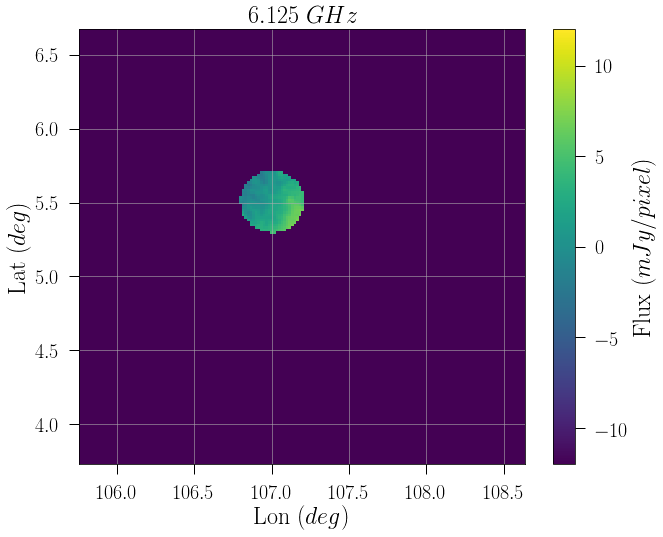

In [99]:
signal, rabins, decbins = calculate_sflux_gal('C')

In [88]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    rc = 107.2
    dc = 5.2
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    annulus = (radius >= 1. ) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0

    if smth is None:
        smth = beam
    if smth > 0:
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma)
        shits = gaussian_filter(hits, sigma)
        mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())
    
    signal[~innerregion] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-12, 12)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        grid(alpha=0.7)
        title('$%.3f~GHz$' %cfreq)
    
    return signal, rabins, decbins

27.213675791 0.280616079357


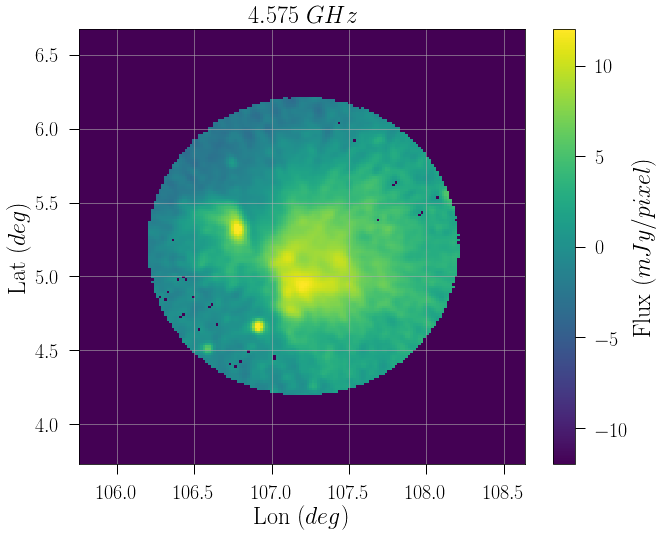

In [89]:
signal, rabins, decbins = calculate_sflux_gal('A')

27.5203404173 0.426399228569


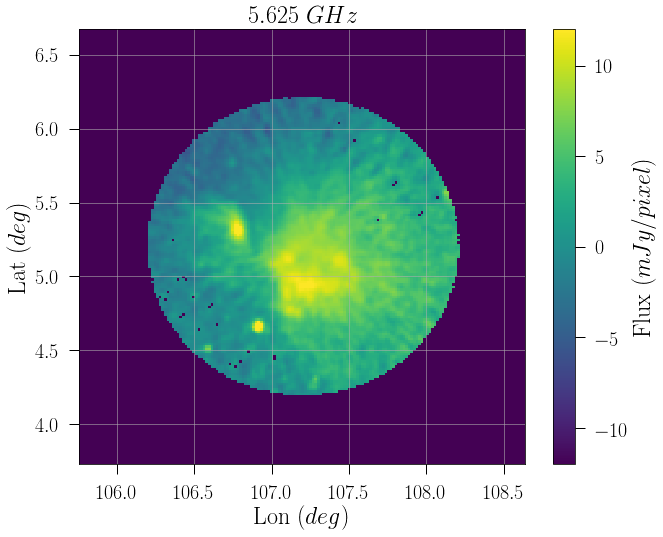

In [90]:
signal, rabins, decbins = calculate_sflux_gal('B')

27.7982046948 0.52513563182


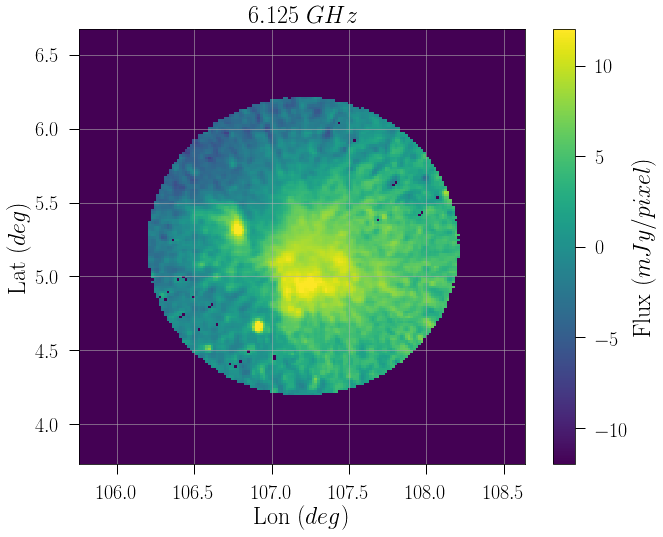

In [91]:
signal, rabins, decbins = calculate_sflux_gal('C')